Track lifecycle analysis
============

This code demonstrates how to perform lifecycle analysis of a couple of properties (area and rainrate_heavyrain).
The individual lifecycles are interpolated onto a common lifecycle, then percentiles are calculated.

In [1]:
import datetime as dt
import itertools
from pathlib import Path
import shutil

import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy import interpolate
import xarray as xr

%matplotlib inline

Load all tracks from 2000/6-2020/12

In [2]:
# Edit these based on where these are on your system.
statsdir = Path('/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/stats')
pixeldir = Path('/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/mcstracking')

In [3]:
stats_paths = sorted(statsdir.glob('mcs_tracks_final_extc_????????.0000_????????.0000.nc'))
print(stats_paths[0])
print(stats_paths[-1])

/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/stats/mcs_tracks_final_extc_20000601.0000_20010101.0000.nc
/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/stats/mcs_tracks_final_extc_20200101.0000_20210101.0000.nc


In [4]:
# A single year can be opened using:
dstracks_2020 = xr.open_dataset(stats_paths[-1])

area
0.0%
10.4%
20.9%
31.3%
41.8%
52.2%
62.6%
73.1%
83.5%
93.9%
0.0%
6.6%
13.2%
19.8%
26.4%
33.0%
39.6%
46.2%
52.8%
59.4%
66.0%
72.6%
79.2%
85.8%
92.4%
99.0%
0.0%
13.6%
27.1%
40.7%
54.2%
67.8%
81.4%
94.9%
rainrate_heavyrain
0.0%
10.4%
20.9%
31.3%
41.8%
52.2%
62.6%
73.1%
83.5%
93.9%
0.0%
6.6%
13.2%
19.8%
26.4%
33.0%
39.6%
46.2%
52.8%
59.4%
66.0%
72.6%
79.2%
85.8%
92.4%
99.0%
0.0%
13.6%
27.1%
40.7%
54.2%
67.8%
81.4%
94.9%


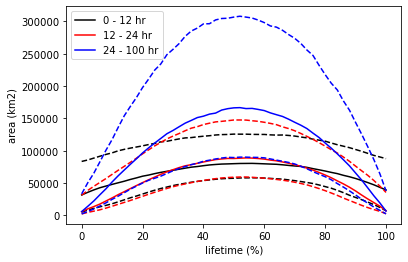

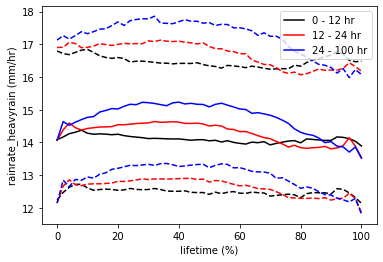

In [6]:
dstracks = dstracks_2020

def gen_lifecycle_percentiles(subtracks, variable):
    """Generate lifecylce values of 25, 50, 75 percentile values for given variable in subtracks
    
    Interpolates the variable onto a common timeseries, appends all of these to a list,
    then performs the percentile over each individual lifecycle."""
    subtracks.track_duration.load()
    subtracks[variable].load()
    lifecycles = []
    ntracks = len(subtracks.tracks)
    for track_id in range(ntracks):
        if track_id % 1000 == 0:
            print(f'{(track_id + 1) / ntracks * 100:.1f}%')
            
        duration = subtracks.track_duration.values[track_id]
        fn = interpolate.interp1d(np.arange(duration), subtracks[variable].values[track_id, :duration])
        lifecycles.append(fn(np.linspace(0, duration - 1, 51)))
    lifecycles = np.array(lifecycles)
    p25, p50, p75 = np.nanpercentile(lifecycles, [25, 50, 75], axis=0)
    return p25, p50, p75


def plot_lifetimes(p25, p50, p75, variable, units, mindur, maxdur, colour):
    label = f'{mindur} - {maxdur} hr'
    plt.plot(np.linspace(0, 100, 51), p50, linestyle='-', color=colour, label=label)
    plt.plot(np.linspace(0, 100, 51), p25, linestyle='--', color=colour)
    plt.plot(np.linspace(0, 100, 51), p75, linestyle='--', color=colour)
    plt.legend()
    plt.xlabel('lifetime (%)')
    plt.ylabel(f'{variable} ({units})')


# for variable, units in [('rainrate_heavyrain', 'mm/hr')]:
for variable, units in [('area', 'km2'), ('rainrate_heavyrain', 'mm/hr')]:
    print(variable)
    plt.figure()
    for mindur, maxdur, colour in [(0, 12, 'k'), (12, 24, 'r'), (24, 100, 'b')]:
        mask = (dstracks.track_duration > mindur) & (dstracks.track_duration <= maxdur)
        with dask.config.set(**{'array.slicing.split_large_chunks': False}):
            subtracks = dstracks.isel(tracks=mask)
        p25, p50, p75 = gen_lifecycle_percentiles(subtracks, variable)
        ds = xr.Dataset(
            data_vars=dict(p25=('lifetime', p25), p50=('lifetime', p50), p75=('lifetime', p75)),
            coords=dict(lifetime=np.linspace(0, 1, len(p25)))
        )
        plot_lifetimes(p25, p50, p75, variable, units, mindur, maxdur, colour)
            
    plt.plot()